![Olist](Olist_pics/logo-olist.png)

# Seller Segmentation based on avg LTV

Segment merchants based on avg LTV. What does it take to be a top seller? 

01. Random Forest Regressor model that predicts 1-month avg LTV
02. Feature Importance 
03. Partial Dependant Plots to find segments

In [1]:
#Importing Libraries & set up
import byMontse as byM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import datetime,date,timedelta 
import datetime as dt
import calendar

#NLP
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from wordcloud import WordCloud, STOPWORDS

#ML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier, plot_tree
from sklearn import tree

#PDP
from pdpbox import pdp, info_plots

#Image and options
import graphviz
from graphviz import Source
from IPython.display import Image
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)

# Configure visualizations
%matplotlib inline
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'grid.linestyle': '--','figure.figsize': [8,6], 'font.size': 16}
sns.set_theme(style='ticks', rc=custom_params)
base_color=sns.color_palette()[0]

#Warnings managemnet
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
seller=pd.read_csv('Olist_saved/seller_df.csv')
byM.datasummary(seller).fillna('')

Dataset Shape: (765, 32)


,dtypes,count,unique,missing,top,freq,mean,std,min,25%,50%,75%,max,First Value
seller_id,object,765.0,765,0,6aa3928696eab49a19a466e665a649fd,1,,,,,,,,2c43fb513632d29b3b58df74816f1b06
sdr_id,object,765.0,22,0,4b339f9567d060bcea4f5136b9f5949e,137,,,,,,,,a8387c01a09e99ce014107505b92388c
sr_id,object,765.0,18,0,4ef15afb4b2723d8f3d81e51ec7afefe,130,,,,,,,,4ef15afb4b2723d8f3d81e51ec7afefe
won_date,object,765.0,146,0,2018-04-30,22,,,,,,,,2018-02-26
business_segment,object,765.0,32,0,home_decor,96,,,,,,,,pet
lead_type,object,765.0,8,0,online_medium,303,,,,,,,,online_medium
lead_behaviour_profile,object,765.0,8,0,cat,373,,,,,,,,cat
business_type,object,765.0,3,0,reseller,529,,,,,,,,reseller
first_contact_date,object,765.0,180,0,2018-02-06,13,,,,,,,,2018-02-21
landing_page_id,object,765.0,122,0,b76ef37428e6799c421989521c0e5077,163,,,,,,,,b48ec5f3b04e9068441002a19df93c6c


In [3]:
# variables gathered
df=seller[['won_month','business_segment','lead_type','lead_behaviour_profile','business_type','contact_month','seller_days_withOlist','origin','seller_acquisition_days','total_sold']]
df['target']=pd.Series(df['total_sold']/df['seller_days_withOlist']*30) # avg LTV (1-month)

No handles with labels found to put in legend.


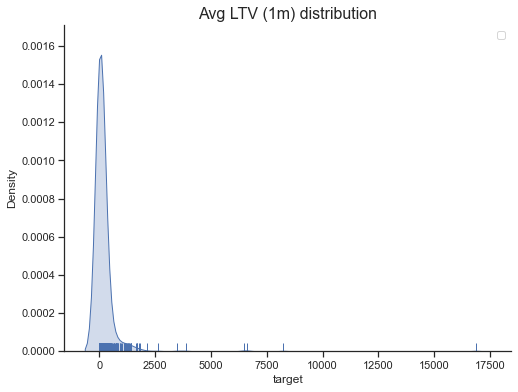

In [4]:
#Distribution of the target
sns.kdeplot(df['target'], 
            shade = True)
sns.rugplot(df['target'])
plt.title('Avg LTV (1m) distribution', fontsize=16)
plt.legend()
plt.savefig('Olist_saved/targetdistribution.png')

In [5]:
# Define X (features) and y (outcome)
X=df.drop(columns=['target','total_sold'])
X=pd.get_dummies(X, drop_first=True)
y=df['target']

# shape
print(X.shape,y.shape)

(765, 61) (765,)


### 0.1 Random Forest Regressor

I picked a **random forest classifier** to predict sale/no sale. Main reasons: 
- it usually requires very little time to optimize it (its default params are often close to be the best ones) 
- it is strong with outliers, irrelevant variables, continuous and discrete variables.
- overcomes the problem of overfitting by averaging or combining the results of different decision trees.
I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. 


In [6]:
#split into train and test to avoid overfitting
SEED=123 #reproductility
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25, random_state=SEED)

# define the model
rfr = RandomForestRegressor(random_state=SEED, n_estimators=50, max_depth=4, oob_score=True)

#fit the model & predict
rfr.fit(X_train, y_train)
predictions= rfr.predict(X_test)

#error 
mse=mean_squared_error(predictions, y_test)
print('Root mean squared error (in BRL):{:.2f}'.format(np.sqrt(mse)))

Root mean squared error (in BRL):363.94


In [7]:
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)
n_scores = cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
rmse_scores=np.sqrt(abs(n_scores))
print('RMSE: %.2f (%.2f)' % (np.mean(rmse_scores), np.std(rmse_scores)))

RMSE: 777.17 (468.58)


In [8]:
#Hyperparameter tunning with GridSearchCV

rf=RandomForestRegressor(random_state=SEED, oob_score=True)
params_rfr = {'n_estimators':[50,100,350,500],
                'max_features':['log2','auto','sqrt'],
                'min_samples_leaf':[5,10,20,30]}
# Instantiate grid_rf
grid_rfr = GridSearchCV(estimator=rf,
                       param_grid=params_rfr,
                       scoring='neg_root_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)
# fit
grid_rfr.fit(X_train, y_train)
# Extract the best estimator
best_estimator=grid_rfr.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [9]:
best_estimator

{'max_features': 'auto', 'min_samples_leaf': 30, 'n_estimators': 500}

In [10]:
# define the model
rfr = RandomForestRegressor(random_state=SEED, n_estimators=best_estimator.get('n_estimators'), min_samples_leaf=best_estimator.get('min_samples_leaf'),max_features=best_estimator.get('max_features'),oob_score=True)

#fit the model & predict
rfr.fit(X_train, y_train)
predictions= rfr.predict(X_test)

#error 
mse=mean_squared_error(predictions, y_test)
print('Root mean squared error (in BRL):{:.2f}'.format(np.sqrt(mse)))

Root mean squared error (in BRL):288.34


In [11]:
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)
n_scores = cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
rmse_scores=np.sqrt(abs(n_scores))
print('RMSE: %.3f (%.3f)' % (np.mean(rmse_scores), np.std(rmse_scores)))

RMSE: 641.738 (517.043)


##### Feature Importances

In [12]:
#Reference levels for the categorical variables
data_categorical = df.select_dtypes(['object']).astype("category") 
#find reference level, i.e. the first level
print(data_categorical.apply(lambda x: x.cat.categories[0]))

business_segment          air_conditioning
lead_type                         industry
lead_behaviour_profile                 cat
business_type                 manufacturer
origin                      direct_traffic
dtype: object


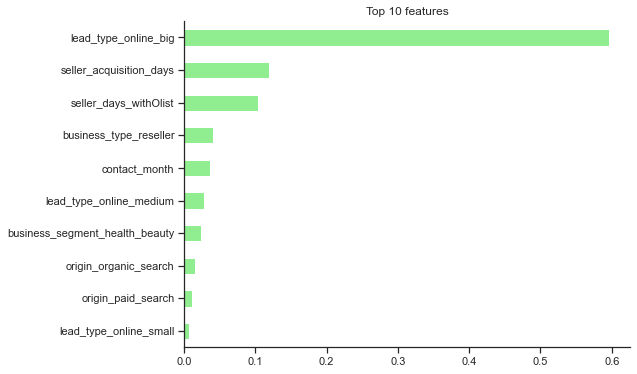

<Figure size 576x432 with 0 Axes>

In [13]:
# Create a pd.Series of features importances
importances_rfr = pd.Series(rfr.feature_importances_, index = X.columns)
# Sort importances_rf                                   
sorted_importances_rfr= importances_rfr.nlargest(10)  
#print(sorted_importances_rfc)
# Make a horizontal bar plot
sorted_importances_rfr.sort_values(ascending=True).plot(kind='barh', color='lightgreen') 
plt.title('Top 10 features')
plt.show()

Standard Feature Importances simply indicates which features were more useful when building the model. They are not to be interpreted as a direct dependence between predictor and target.

The **top 10 most important variables** are listed in the barplot, each with a coefficient which shows how much each variable affects the price. Although, RF Importances are usually biased towards numerical and high cardinality features, in our case **lead type: online big** is the top 1 feature!

### Partial Dependance Plots


Pdp are the most reliable way to extract insights from 'black-box' models like Random Forest. They shows the way the model is extracting info from each variable.

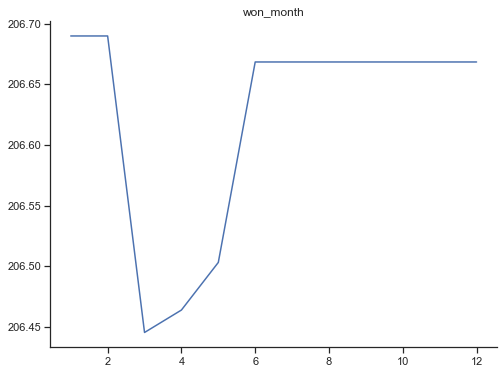

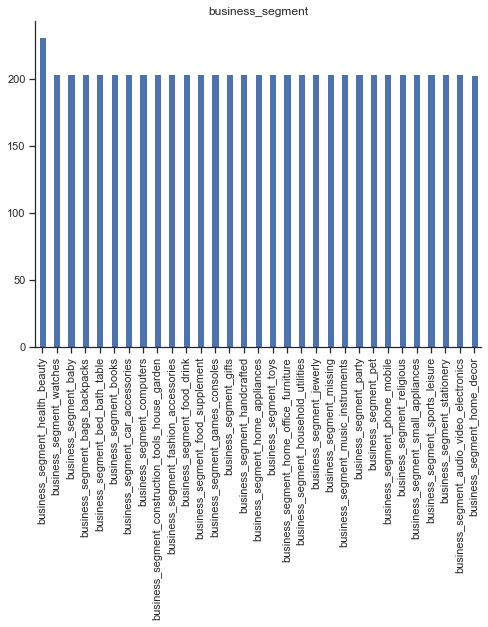

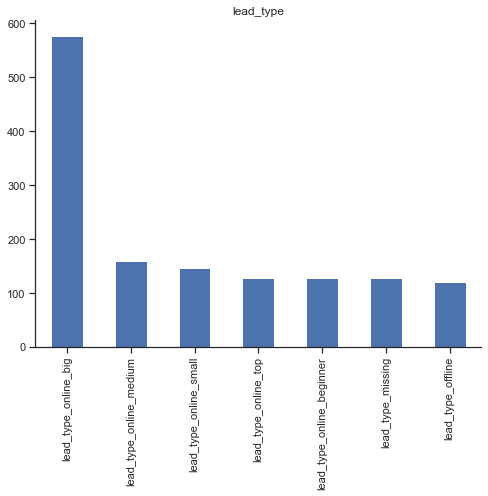

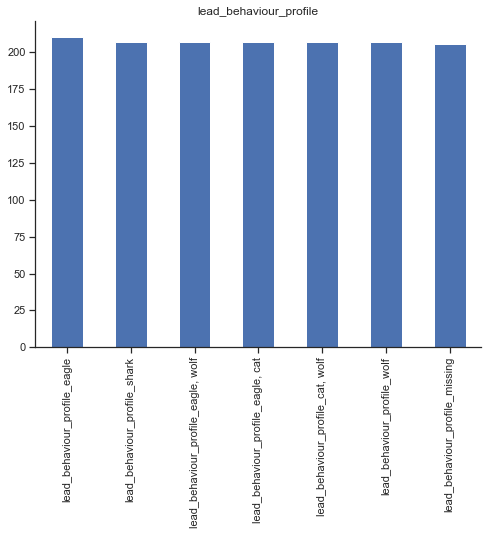

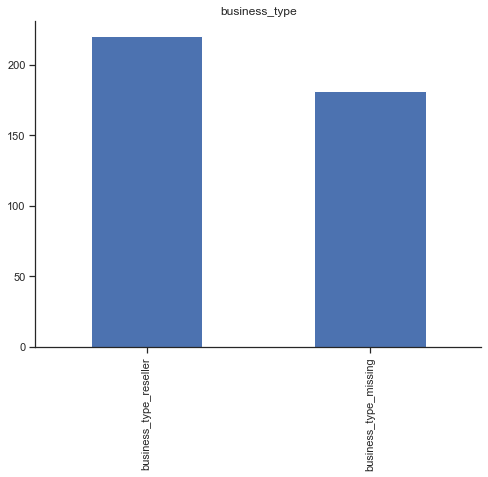

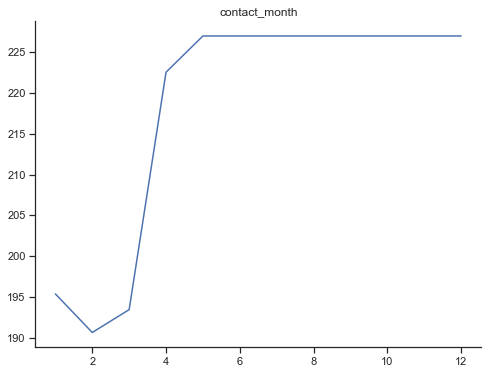

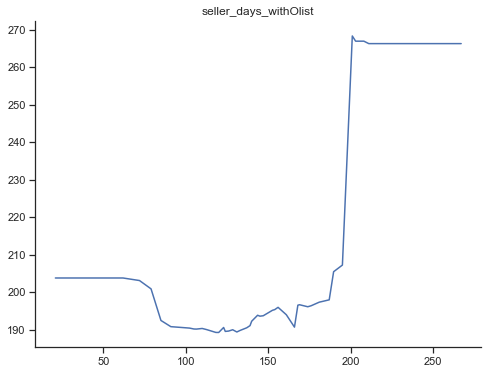

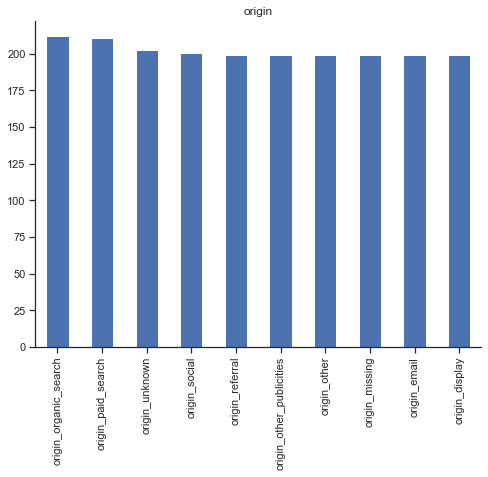

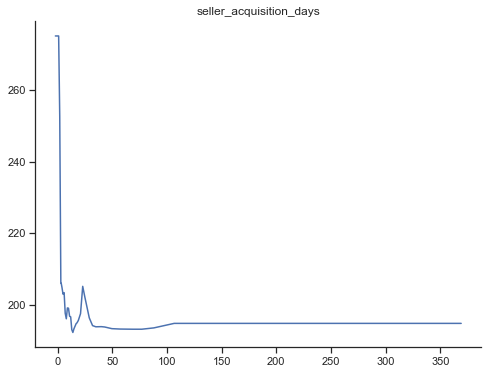

In [14]:
#Let's plot all of them. Note that pdpbox allows to group together dummy variables coming from the same categorical variable. For this we need to get the original variable names.
feat_original = df.columns.drop(['target', 'total_sold'])
  
#plot all variables with a for loop. If a variable is categorical make sure to plot all levels together.
for i in range(len(feat_original)):
    #get all variables that include the name in feat_original. So, if it is numeric, just take that variable. If it is categorical, take all dummies belonging to the same categorical variable. Since for dummies their name is variable_level, this is easy. Just pick all variables that start with the original variable name. I.e. to get all weekday dummies (weekday_Monday, weekday_Tuesday, etc.), we just look for all variables starting with "weekday"
    #variables to plot
    plot_variable = [e for e in list(X) if e.startswith(feat_original[i])]
      
    #numeric variables or dummy with just 1 level
    if len(plot_variable) == 1:
       pdp_iso = pdp.pdp_isolate( model=rfr, dataset=X, model_features=list(X), feature=plot_variable[0], num_grid_points=50)
       pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
       #pdpbox has several options if you want to use their built-in plots. I personally prefer just using .plot. It is totally subjective obviously.
       pdp_dataset.plot(title=feat_original[i])
       plt.show()
         
    #categorical variables with several levels
    else:
       pdp_iso = pdp.pdp_isolate( model=rfr, dataset=X, model_features=list(X),  feature=plot_variable, num_grid_points=50)
       pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
       pdp_dataset.sort_values(ascending=False).plot(kind='bar', title=feat_original[i])
       plt.show()
    plt.close()   

#### Understanding the output

The larger the y-axis scale, the more important is that variable. It essentially shows by how much changing that variable value would impact the output. The money is where the change is the largest. 

- **Lead_type** seems by far the most important variable, specifically online_big (as geature_importances showed before). We need the marketing team to bring more of those users to Olist.
- **Days with Olist** also have a big impact. We can see a big jump in impact (best segment) for sellers that have been with Olist >200 days. It would be very interisting to dig deeper on this in next steps. One assumption may be products become more popular over time because their exposure in all main Brazillian marketplaces.
- **business segment** would be the following most important feature with health and beauty leading it.
- **seller acquision days** doesn't look important. Probably, RF prioritized this variable as it is numerical. Big spike seems given by noise. 

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Root mean squared error (in BRL):289.67
RMSE: 640.199 (517.350)


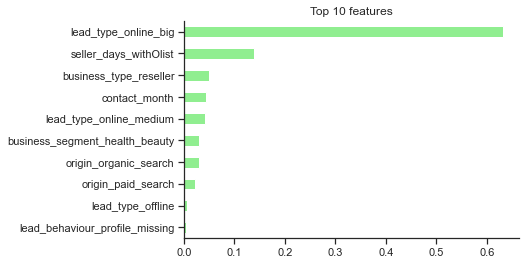

In [17]:
### Redoing the model without seller_acquisition _days variable

# variables gathered
df=seller[['won_month','business_segment','lead_type','lead_behaviour_profile','business_type','contact_month','seller_days_withOlist','origin','total_sold']]
df['target']=pd.Series(df['total_sold']/df['seller_days_withOlist']*30) # avg LTV (1-month)

# Define X (features) and y (outcome)
X=df.drop(columns=['target','total_sold'])
X=pd.get_dummies(X, drop_first=True)
y=df['target']

#split into train and test to avoid overfitting
SEED=123 #reproductility
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25, random_state=SEED)

#Hyperparameter tunning with GridSearchCV
rf=RandomForestRegressor(random_state=SEED, oob_score=True)
params_rfr = {'n_estimators':[50,100,350,500],
                'max_features':['log2','auto','sqrt'],
                'min_samples_leaf':[5,10,20,30]}
# Instantiate grid_rf
grid_rfr = GridSearchCV(estimator=rf,
                       param_grid=params_rfr,
                       scoring='neg_root_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)
# fit
grid_rfr.fit(X_train, y_train)
# Extract the best estimator
best_estimator=grid_rfr.best_params_

# define the model
rfr = RandomForestRegressor(random_state=SEED, n_estimators=best_estimator.get('n_estimators'), min_samples_leaf=best_estimator.get('min_samples_leaf'),max_features=best_estimator.get('max_features'),oob_score=True)
#fit the model & predict
rfr.fit(X_train, y_train)
predictions= rfr.predict(X_test)
#error 
mse=mean_squared_error(predictions, y_test)
print('Root mean squared error (in BRL):{:.2f}'.format(np.sqrt(mse)))

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=SEED)
n_scores = cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
rmse_scores=np.sqrt(abs(n_scores))
print('RMSE: %.3f (%.3f)' % (np.mean(rmse_scores), np.std(rmse_scores)))

# Create a pd.Series of features importances
importances_rfr = pd.Series(rfr.feature_importances_, index = X.columns)
# Sort importances_rf                                   
sorted_importances_rfr= importances_rfr.nlargest(10)  
#print(sorted_importances_rfc)
# Make a horizontal bar plot
sorted_importances_rfr.sort_values(ascending=True).plot(kind='barh', color='lightgreen') 
plt.title('Top 10 features')
plt.savefig('Olist_saved/Top10featuresBRL.png', bbox_inches="tight")
plt.show()